In [1]:
!pip install netcdf4 h5netcdf
!pip install gcsfs

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define the list of .nc files to read
file_list = [
    "003_2006_2080_352_360.nc",
    "004_2006_2080_352_360.nc",
    "005_2006_2080_352_360.nc",
    "006_2006_2080_352_360.nc",
    "007_2006_2080_352_360.nc",
    "008_2006_2080_352_360.nc"
]

# Print the size and shape of each dataset before combining
for file in file_list:
    ds_temp = xr.open_dataset(file)
    print(f"Size of {file}: {ds_temp.nbytes / 1e6} MB, Shape: {ds_temp.sizes}")
    ds_temp.close()

# Read the .nc files into an xarray Dataset and add an index to distinguish the origin dataset
datasets = []
for i, file in enumerate(file_list):
    ds_temp = xr.open_dataset(file)
    ds_temp = ds_temp.assign_coords(dataset_index=i)
    ds_temp = ds_temp.expand_dims('dataset_index')
    datasets.append(ds_temp)

# Combine the datasets along the 'time' dimension
ds = xr.concat(datasets, dim='time')

# Display the dataset
ds

Size of 003_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of 004_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of 005_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of 006_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of 007_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})
Size of 008_2006_2080_352_360.nc: 65.259684 MB, Shape: Frozen({'time': 27374, 'lat': 11, 'lon': 6})


<xarray.Dataset> Size: 2GB
Dimensions:        (dataset_index: 6, time: 164244, lat: 11, lon: 6)
Coordinates:
  * lat            (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon            (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * dataset_index  (dataset_index) int64 48B 0 1 2 3 4 5
  * time           (time) object 1MB 2006-01-02 00:00:00 ... 2080-12-31 00:00:00
Data variables:
    TREFMXAV_U     (dataset_index, time, lat, lon) float32 260MB nan nan ... nan
    FLNS           (dataset_index, time, lat, lon) float32 260MB 76.48 ... 75.48
    FSNS           (dataset_index, time, lat, lon) float32 260MB 44.47 ... 9.14
    PRECT          (dataset_index, time, lat, lon) float32 260MB 1.158e-08 .....
    PRSN           (dataset_index, time, lat, lon) float32 260MB 0.0 ... 1.98...
    QBOT           (dataset_index, time, lat, lon) float32 260MB 0.005241 ......
    TREFHT         (dataset_index, time, lat, lon) float32 260MB 284.4 ... 280.9
    UBOT           (dataset_index, time, lat, lon) float32 260MB 7.604 ... 7.6
    VBOT           (dataset_index, time, lat, lon) float32 260MB -3.69 ... 5.44

In [4]:
np.unique(ds.isel(time=slice(0,3), dataset_index=0)['time'])

array([cftime.DatetimeNoLeap(2006, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 4, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [5]:
# Convert the DataArray to a pandas Series
lat_series = ds["lat"].to_series()
lon_series = ds["lon"].to_series()

# Get unique values
unique_lat = len(lat_series)
unique_lon = len(lon_series)

print("Unique Lat:", unique_lat)
print("Unique Lat:", unique_lon)      

Unique Lat: 11
Unique Lat: 6


In [6]:
def convert_longitude_360_to_180(lon_360):
    """Converts longitude from 0-360 to -180 to 180 range."""
    lon_180 = lon_360
    if lon_360 > 180:
        lon_180 = lon_360 - 360
    return lon_180

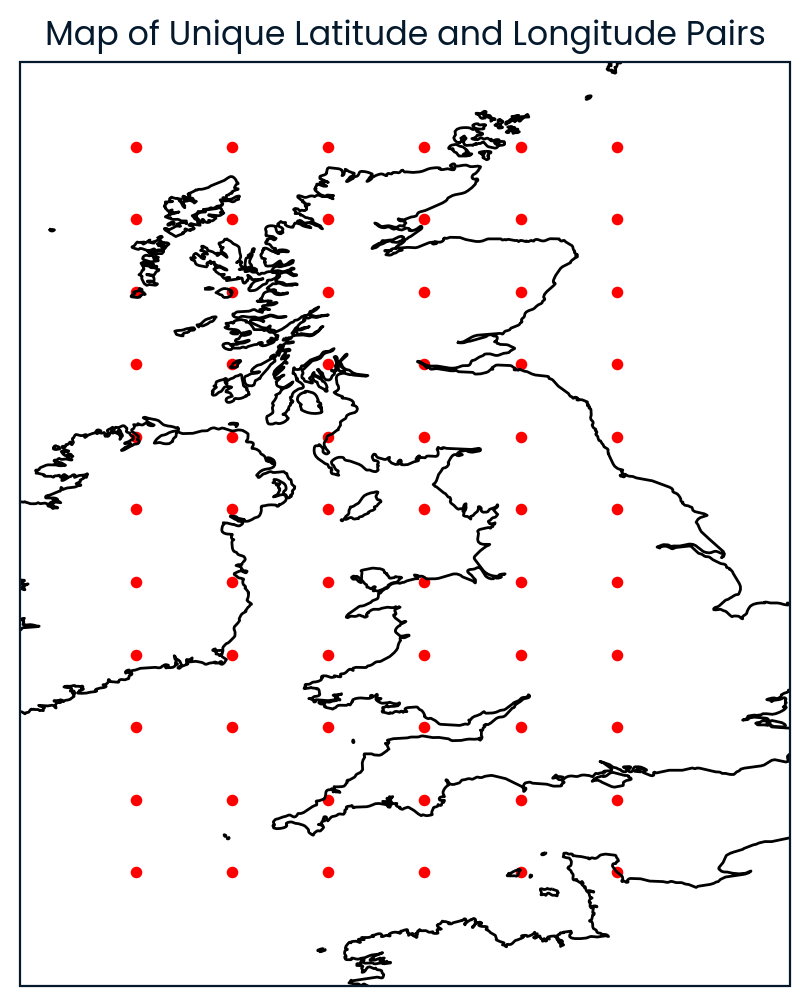

In [7]:
# Extract unique pairs of latitude and longitude
unique_lat_lon_pairs = ds[['lat', 'lon']].to_dataframe().drop_duplicates().reset_index()
unique_lat_lon_pairs['count'] = 1

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-9, 1, 48, 60], crs=ccrs.PlateCarree())  # Set extent to focus on the UK
ax.coastlines()

# Plot the unique latitude and longitude pairs
ax.scatter(unique_lat_lon_pairs['lon'], unique_lat_lon_pairs['lat'], color='red', s=10, transform=ccrs.PlateCarree())

# Set the title of the plot
ax.set_title('Map of Unique Latitude and Longitude Pairs')
# Show the plot
plt.show()

Preprocessing Steps

In [8]:
# Transform TREFMXAV_U from Kelvin to Celsius
ds['TREFMXAV_U'] = ds['TREFMXAV_U'] - 273.15

# Create decade coord
ds = ds.assign_coords(decade=(ds['time'].dt.year // 10) * 10)

## Early future vs Late future Changes by Dataset

In [9]:
# List of attributes to process
attributes = ['TREFHT','TREFMXAV_U', 'FLNS', 'FSNS','PRECT','PRSN','QBOT','UBOT','VBOT']  # Replace with actual attribute names

# Dictionary to store results for each attribute
results = pd.DataFrame()

for attribute in attributes:

    # Group data by decade and compute the mean value for the attribute
    mean_by_decade = ds[attribute].groupby(['decade', 'dataset_index']).mean()

    # Convert the result to a DataFrame for easier inspection
    mean_by_decade_df = mean_by_decade.to_dataframe().reset_index()
    mean_by_decade_df = mean_by_decade_df.groupby(['decade', 'dataset_index'])[attribute].mean()

    temp_early_dec = mean_by_decade_df[mean_by_decade_df.index.isin([(2030,)])]
    temp_early_dec = temp_early_dec.reset_index()
    temp_early_dec['period'] = 'early'

    temp_lat_dec = mean_by_decade_df[mean_by_decade_df.index.isin([(2070,)])]
    temp_lat_dec = temp_lat_dec.reset_index()
    temp_lat_dec['period'] = 'later'

    combined_temp = pd.concat([temp_lat_dec, temp_early_dec])

    # Create a pivot table
    pivot_table = combined_temp.pivot_table(index='dataset_index', columns='period', values=attribute)

    # Calculate the delta between 'later' and 'early' periods
    pivot_table['delta'] = pivot_table['later'] - pivot_table['early']

    # Calculate the standard deviation for the deltas
    delta_std = pivot_table['delta'].std()

    # Calculate the average change in percentage
    pivot_table['percent_change'] = (pivot_table['delta'] / pivot_table['early']) * 100
    average_percent_change = pivot_table['percent_change'].mean()

    pivot_table['attribute'] = attribute
    pivot_table = pivot_table[['attribute', 'early', 'later', 'delta']]
    results = pd.concat([results, pivot_table])
    
    # Display results for each attribute
    print(attribute)
    print("Average change (%)", average_percent_change)
    print("Delta std:", delta_std)
    display(pivot_table[['early', 'later', 'delta']])

TREFHT
Average change (%) 0.5575621
Delta std: 0.14695051


period              early       later     delta
dataset_index                                  
0              285.061035  286.371124  1.310089
1              285.022064  286.616852  1.594788
2              284.867432  286.517334  1.649902
3              285.289062  286.860870  1.571808
4              284.723633  286.438354  1.714722
5              284.681152  286.371826  1.690674

TREFMXAV_U
Average change (%) 11.867394
Delta std: 0.12668422


period             early      later     delta
dataset_index                                
0              14.956687  16.507235  1.550548
1              14.932655  16.694687  1.762032
2              14.831085  16.552017  1.720932
3              15.175507  16.965164  1.789658
4              14.596094  16.533541  1.937447
5              14.635066  16.445021  1.809955

FLNS
Average change (%) -1.7366601
Delta std: 0.7102481


period             early      later     delta
dataset_index                                
0              48.653706  48.010216 -0.643490
1              48.392082  47.973248 -0.418835
2              49.230507  47.830647 -1.399860
3              48.792885  48.496208 -0.296677
4              48.664394  48.343655 -0.320740
5              49.387173  47.351795 -2.035378

FSNS
Average change (%) 2.7590864
Delta std: 1.7335935


period              early       later     delta
dataset_index                                  
0              110.073502  113.086197  3.012695
1              108.564651  112.965591  4.400940
2              111.140800  112.321548  1.180748
3              110.161255  114.585670  4.424416
4              108.929283  113.400360  4.471077
5              110.447517  111.088684  0.641167

PRECT
Average change (%) 3.1185694
Delta std: 1.4836579e-09


period                early         later         delta
dataset_index                                          
0              4.063637e-08  3.913149e-08 -1.504876e-09
1              3.908783e-08  4.102685e-08  1.939021e-09
2              3.917289e-08  4.212128e-08  2.948386e-09
3              3.902127e-08  4.038450e-08  1.363230e-09
4              3.987365e-08  4.099280e-08  1.119151e-09
5              3.956934e-08  4.100456e-08  1.435225e-09

PRSN
Average change (%) -72.881645
Delta std: 8.946536e-11


period                early         later         delta
dataset_index                                          
0              2.878646e-10  1.073061e-10 -1.805585e-10
1              1.916264e-10  7.439595e-11 -1.172304e-10
2              2.932911e-10  6.415467e-11 -2.291364e-10
3              2.235494e-10  6.525711e-11 -1.582923e-10
4              3.642794e-10  7.709695e-11 -2.871825e-10
5              4.201418e-10  6.041805e-11 -3.597238e-10

QBOT
Average change (%) 10.4367485
Delta std: 8.598304e-05


period            early     later     delta
dataset_index                              
0              0.006673  0.007223  0.000550
1              0.006620  0.007373  0.000754
2              0.006536  0.007315  0.000780
3              0.006775  0.007420  0.000645
4              0.006546  0.007209  0.000663
5              0.006488  0.007229  0.000740

UBOT
Average change (%) 23.281479
Delta std: 0.22715972


period            early     later     delta
dataset_index                              
0              1.924237  2.351543  0.427306
1              2.259040  2.303131  0.044091
2              1.974287  2.350199  0.375912
3              1.877999  2.529079  0.651079
4              1.914953  2.497457  0.582504
5              1.977635  2.598666  0.621031

VBOT
Average change (%) 8.693405
Delta std: 0.14242493


period            early     later     delta
dataset_index                              
0              1.597471  1.611159  0.013688
1              1.608923  1.738189  0.129266
2              1.690744  1.647537 -0.043207
3              1.717225  1.798113  0.080888
4              1.414130  1.722747  0.308617
5              1.470050  1.753632  0.283581

In [10]:
results.to_excel('output.xlsx')

## Time Series Analysis

TREFHT


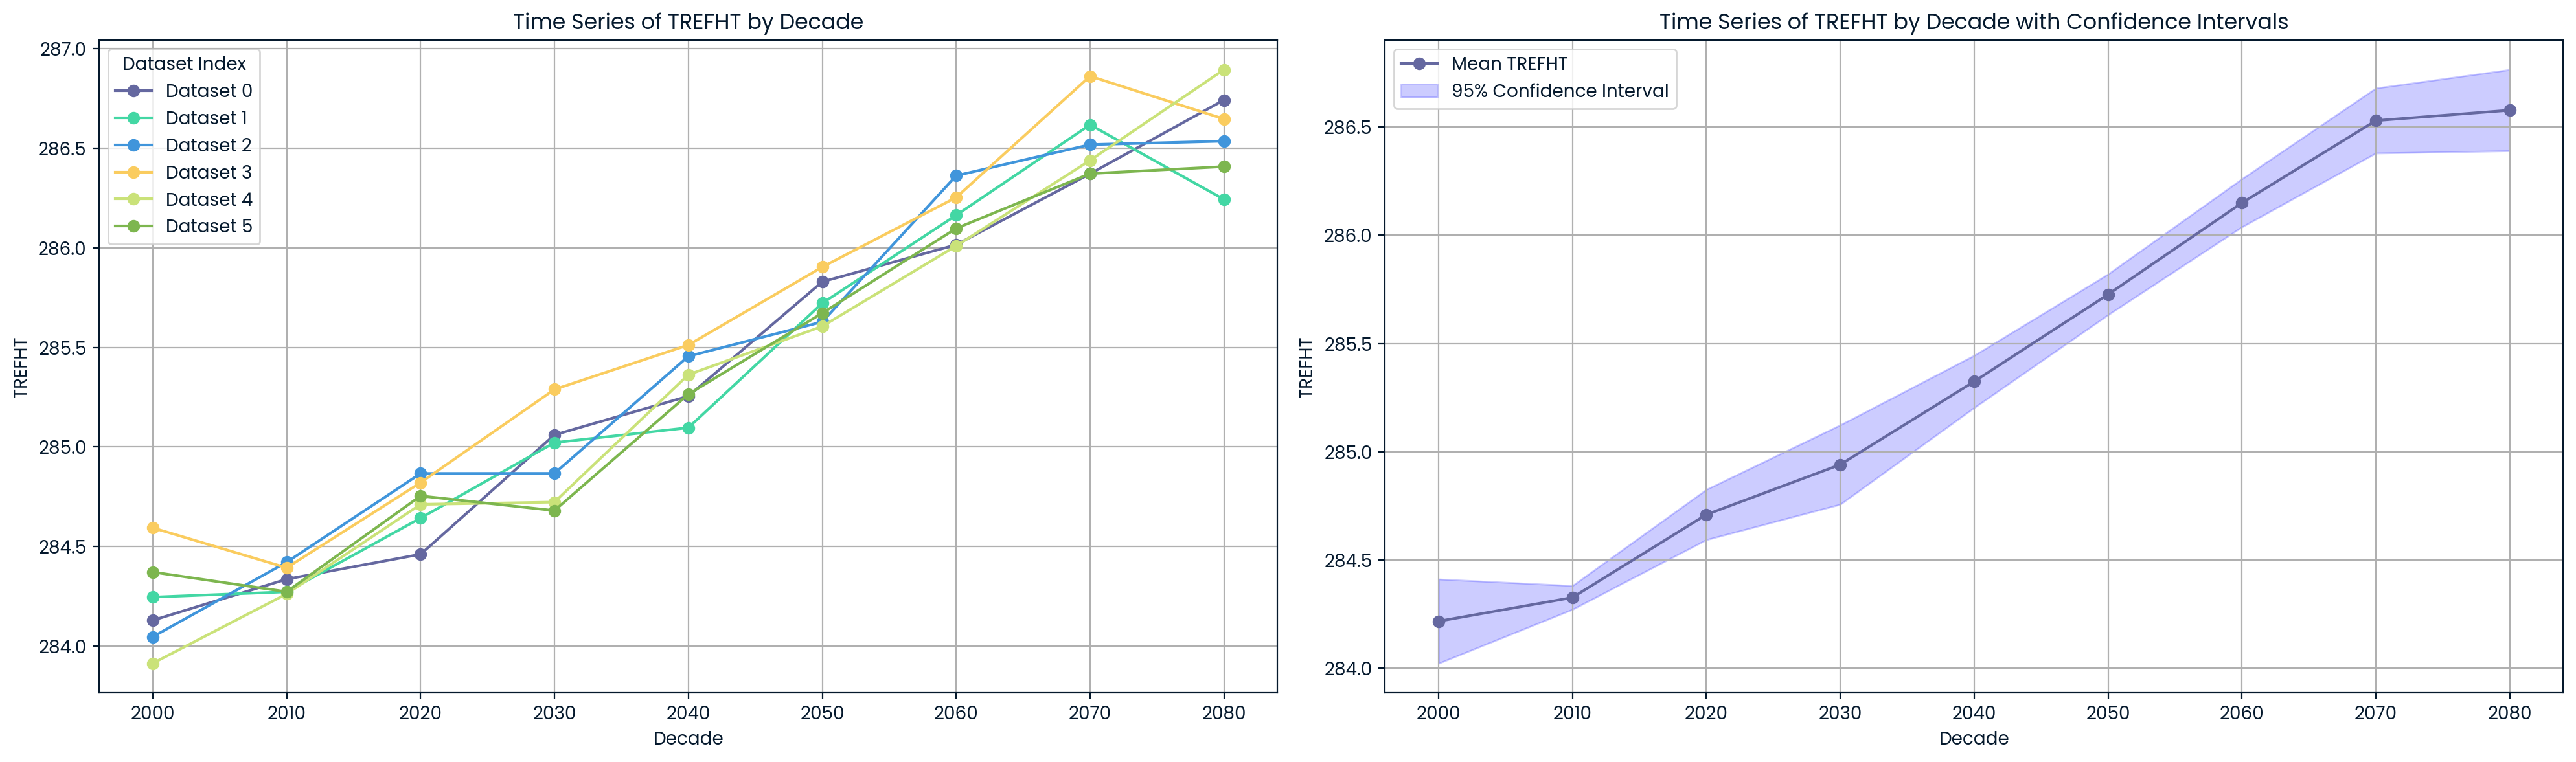

TREFMXAV_U


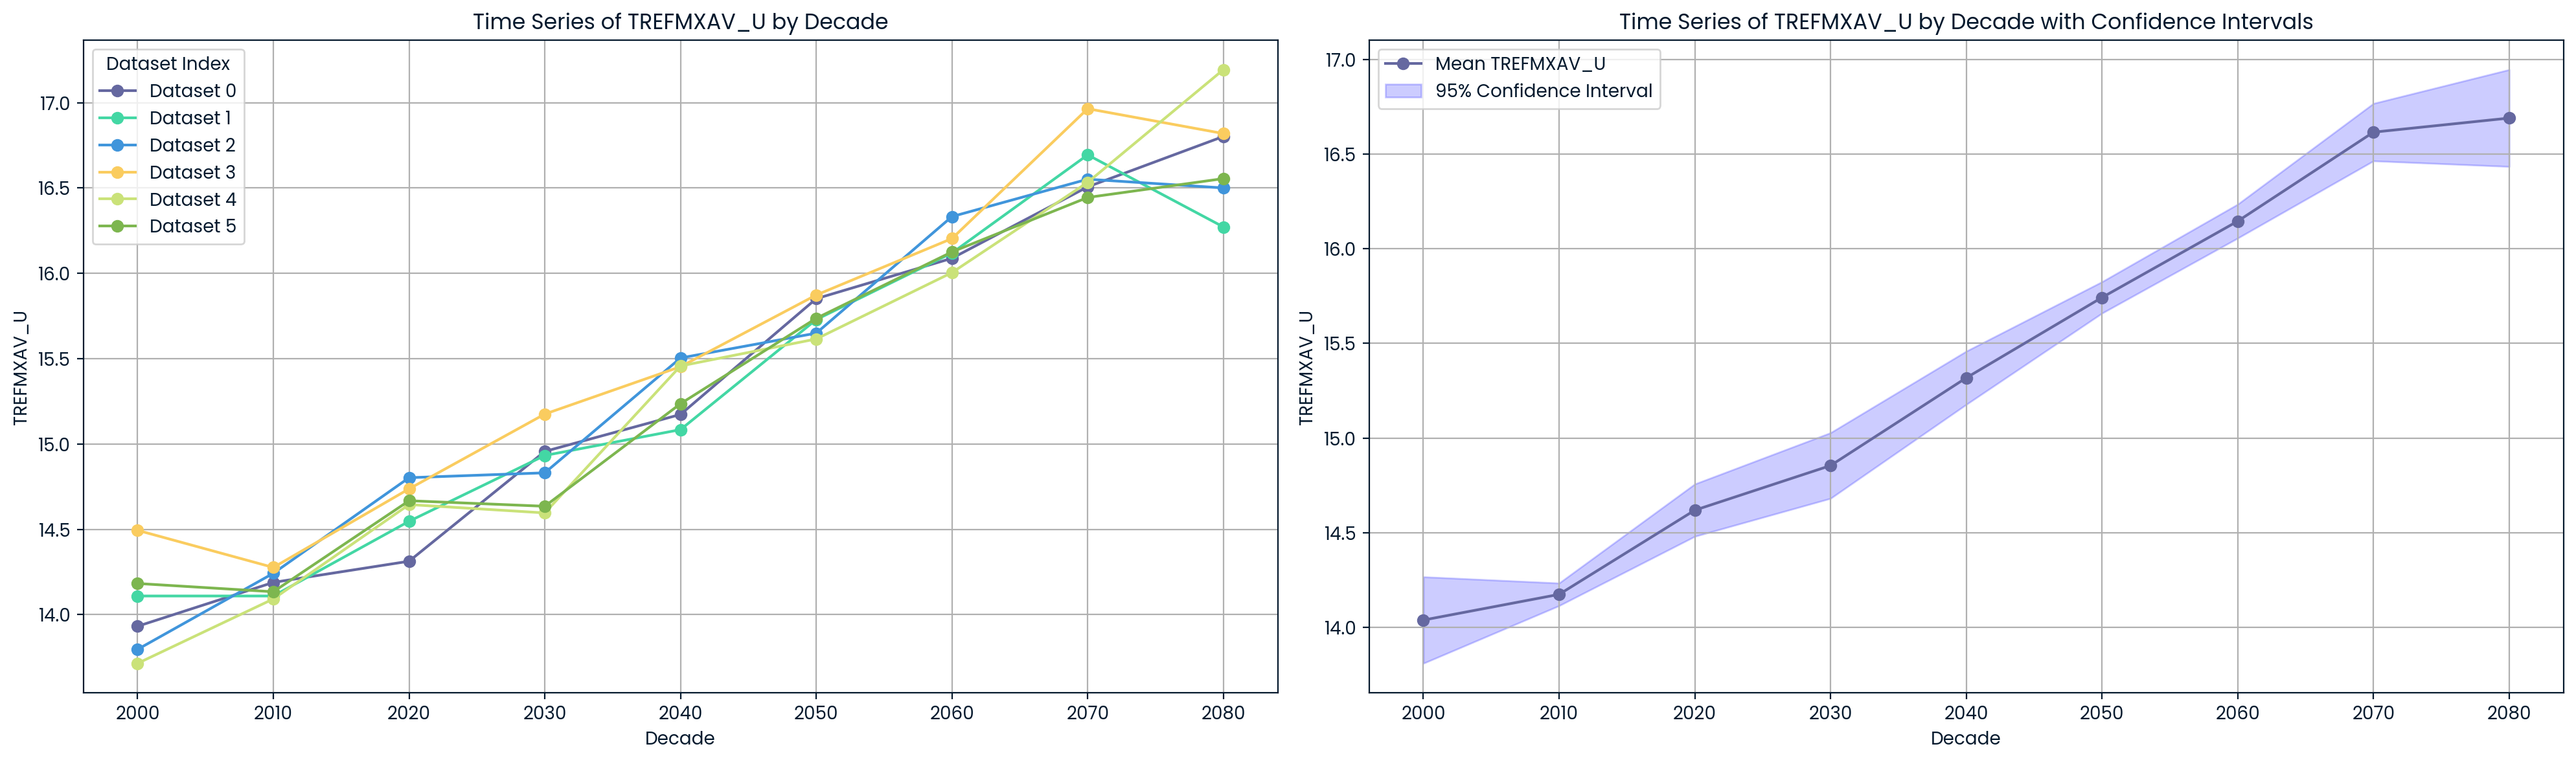

FLNS


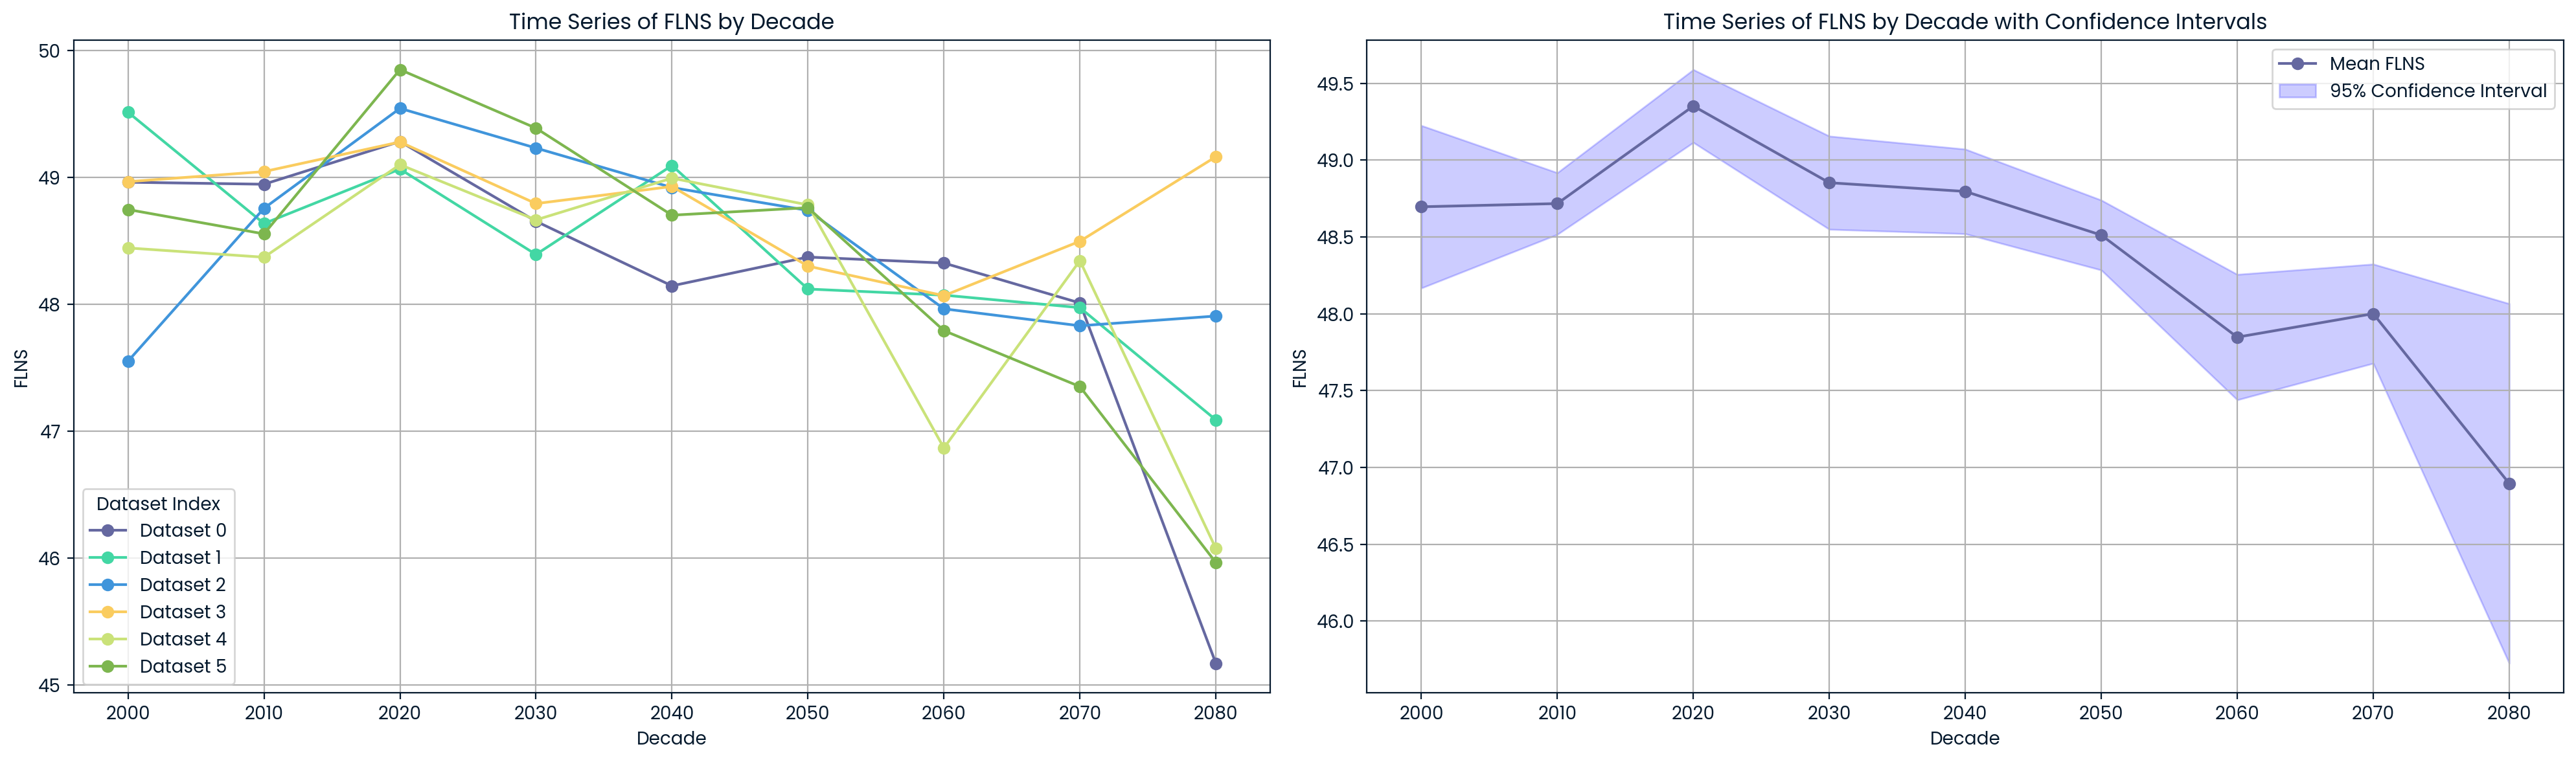

FSNS


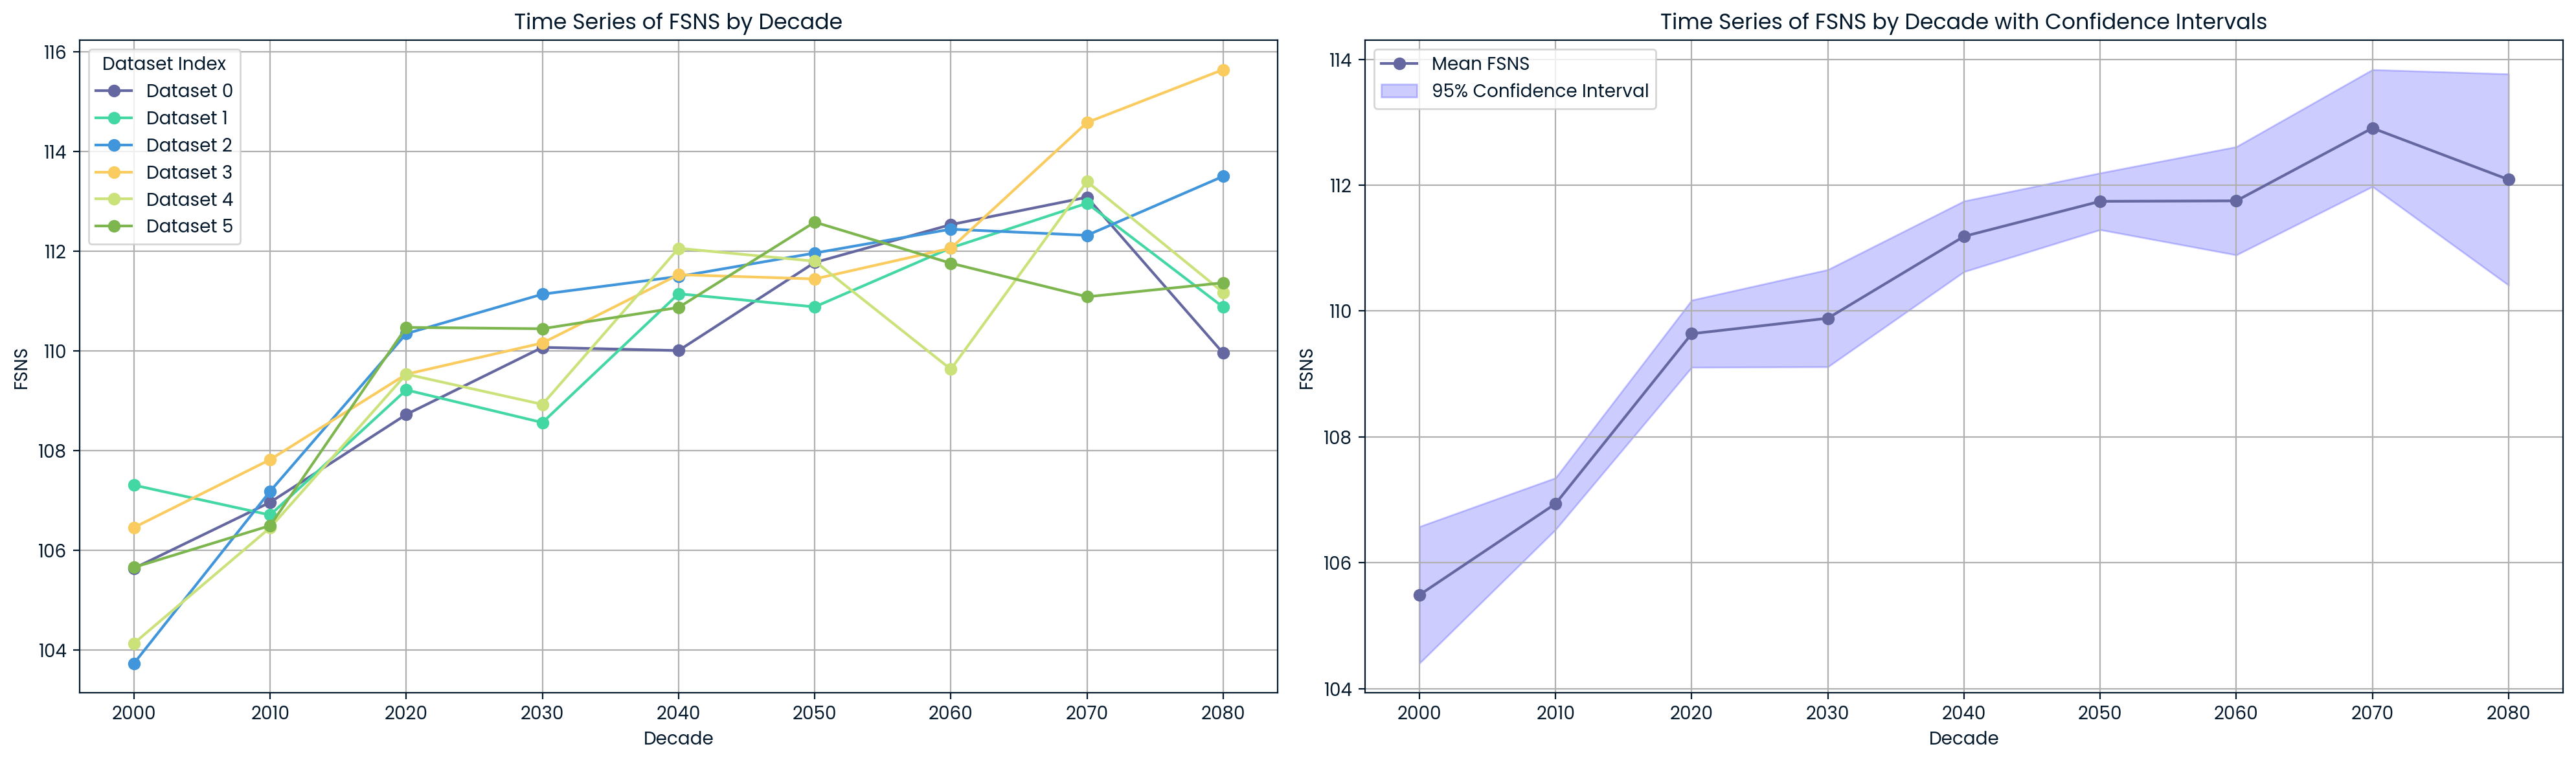

PRECT


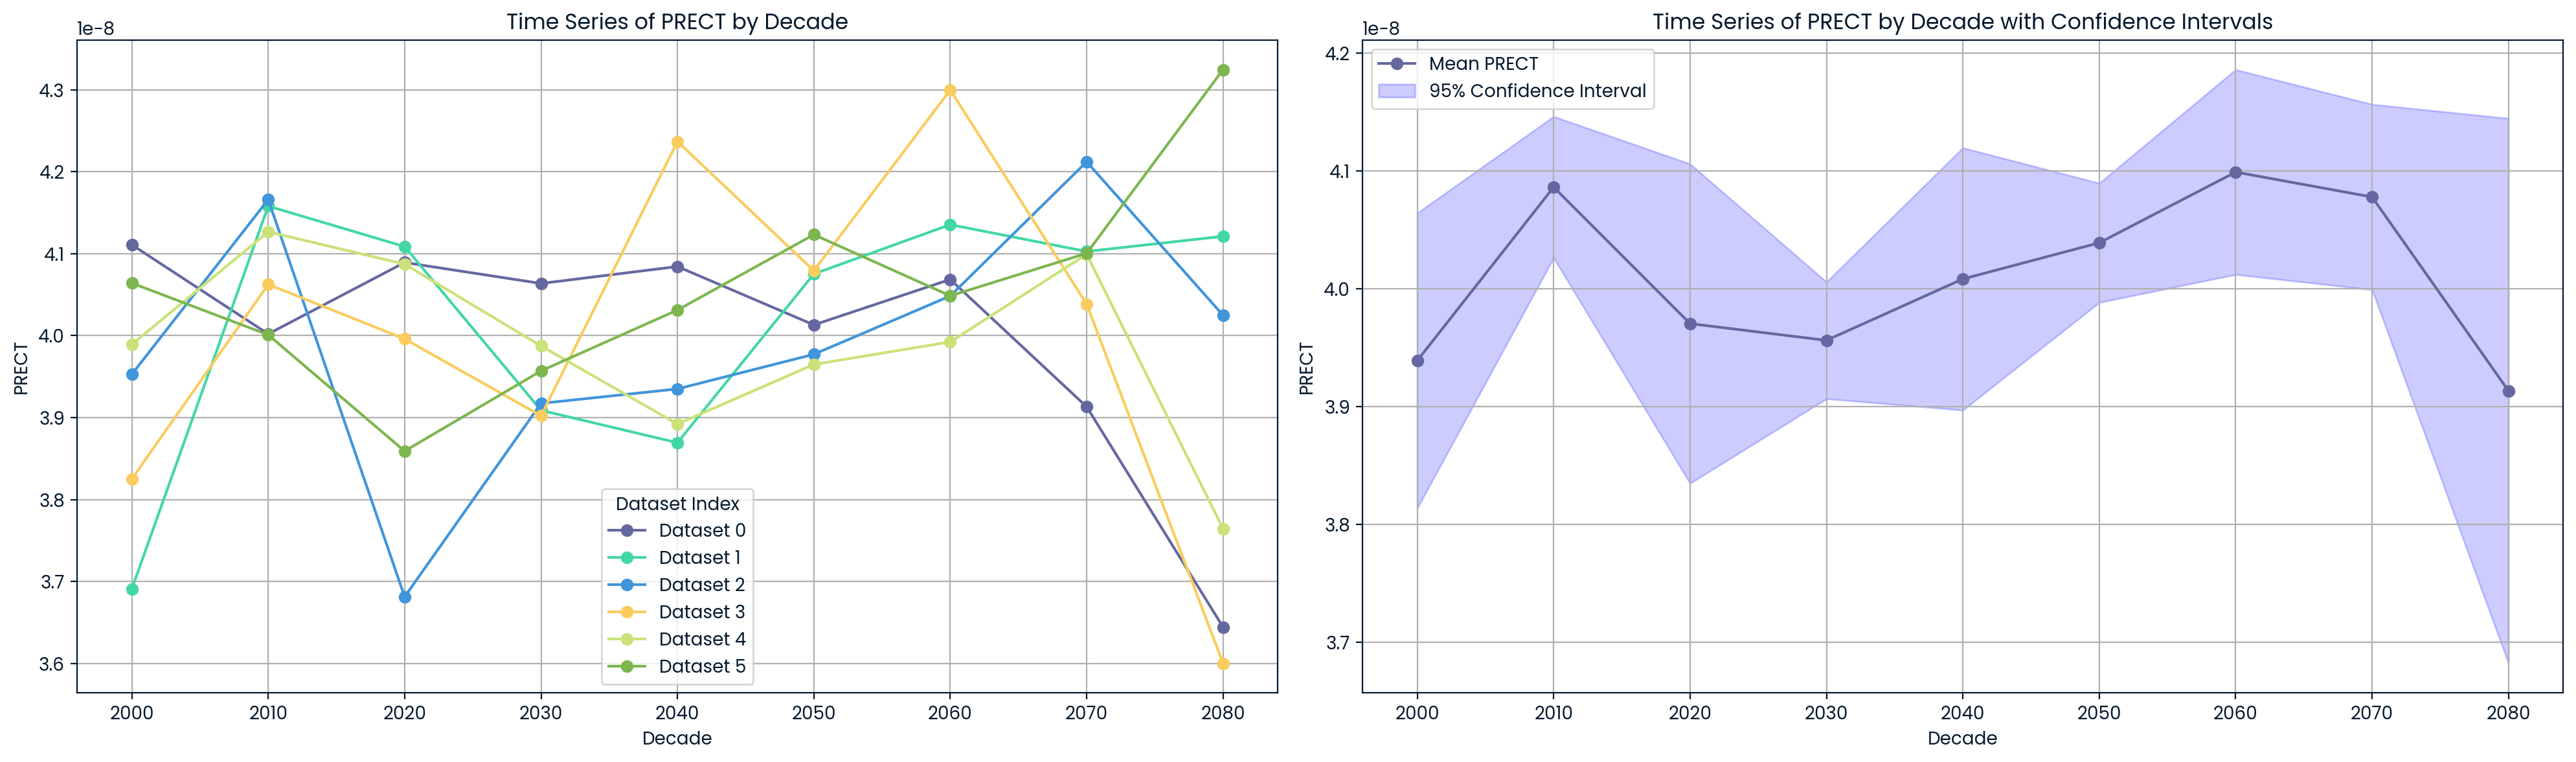

PRSN


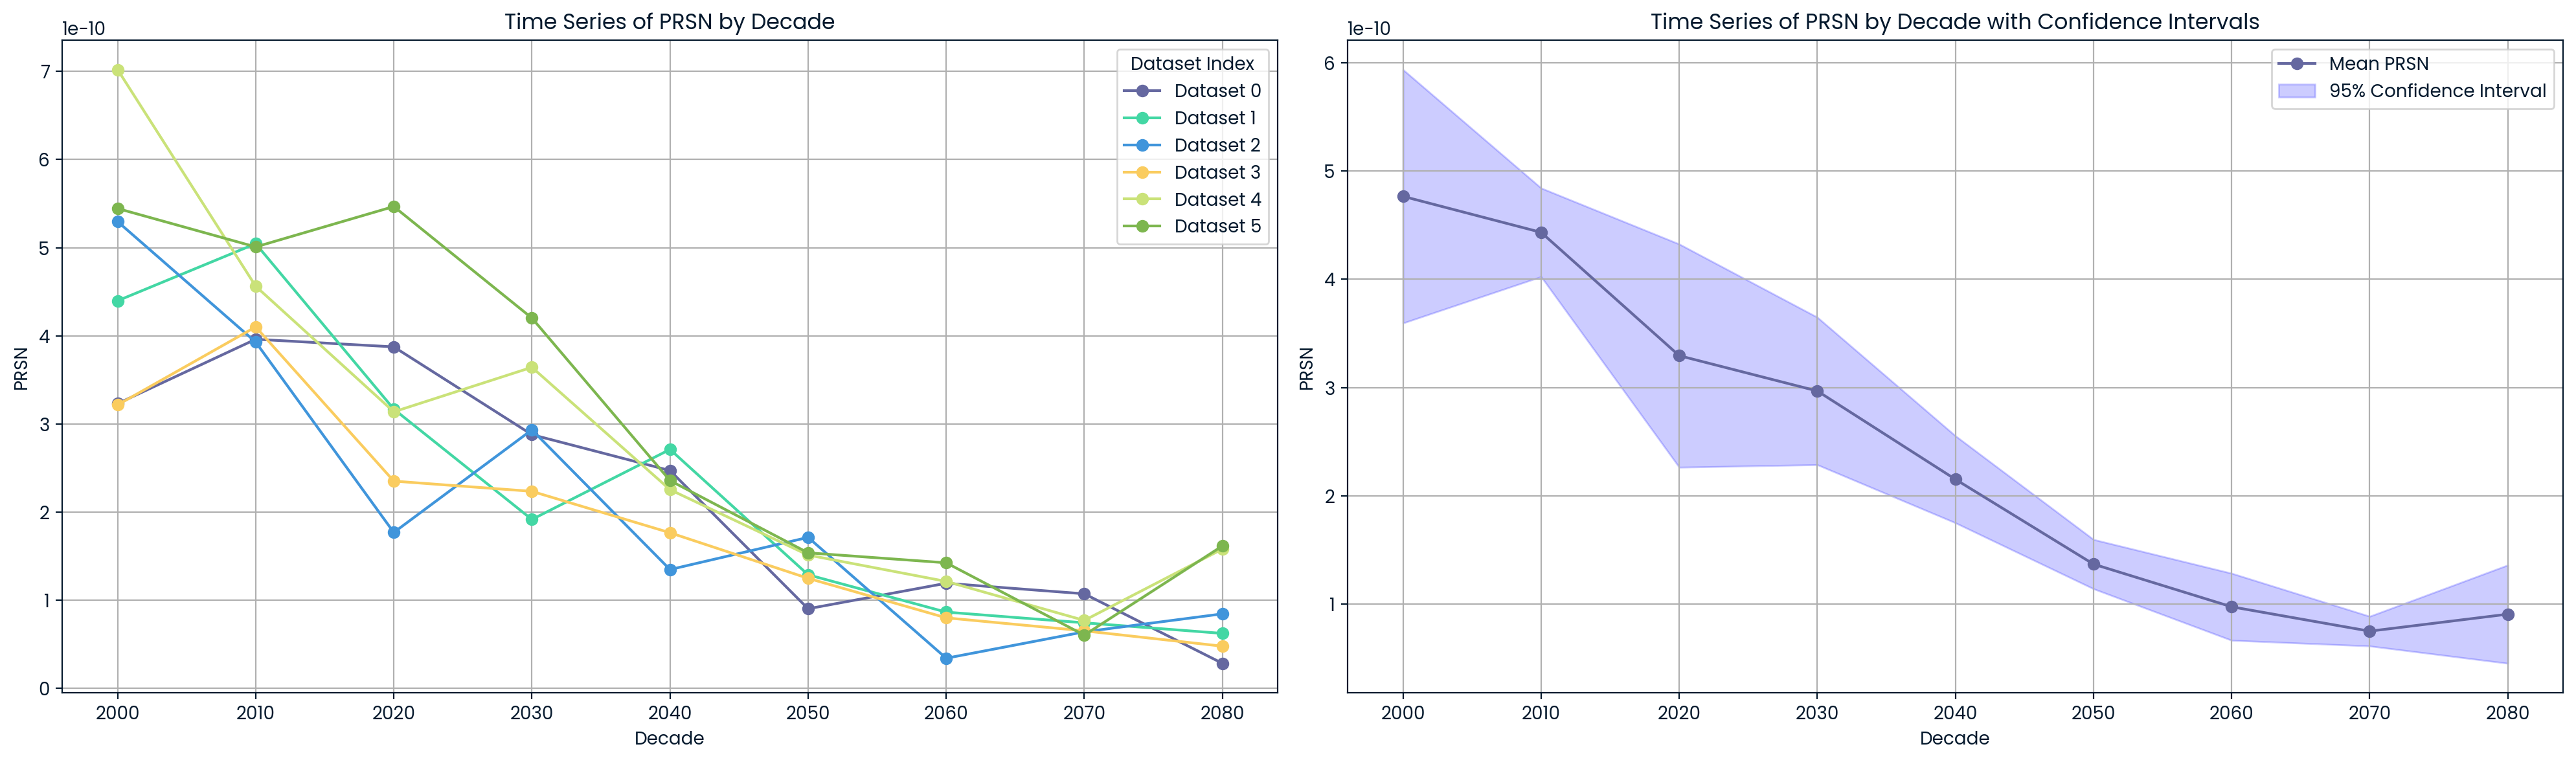

QBOT


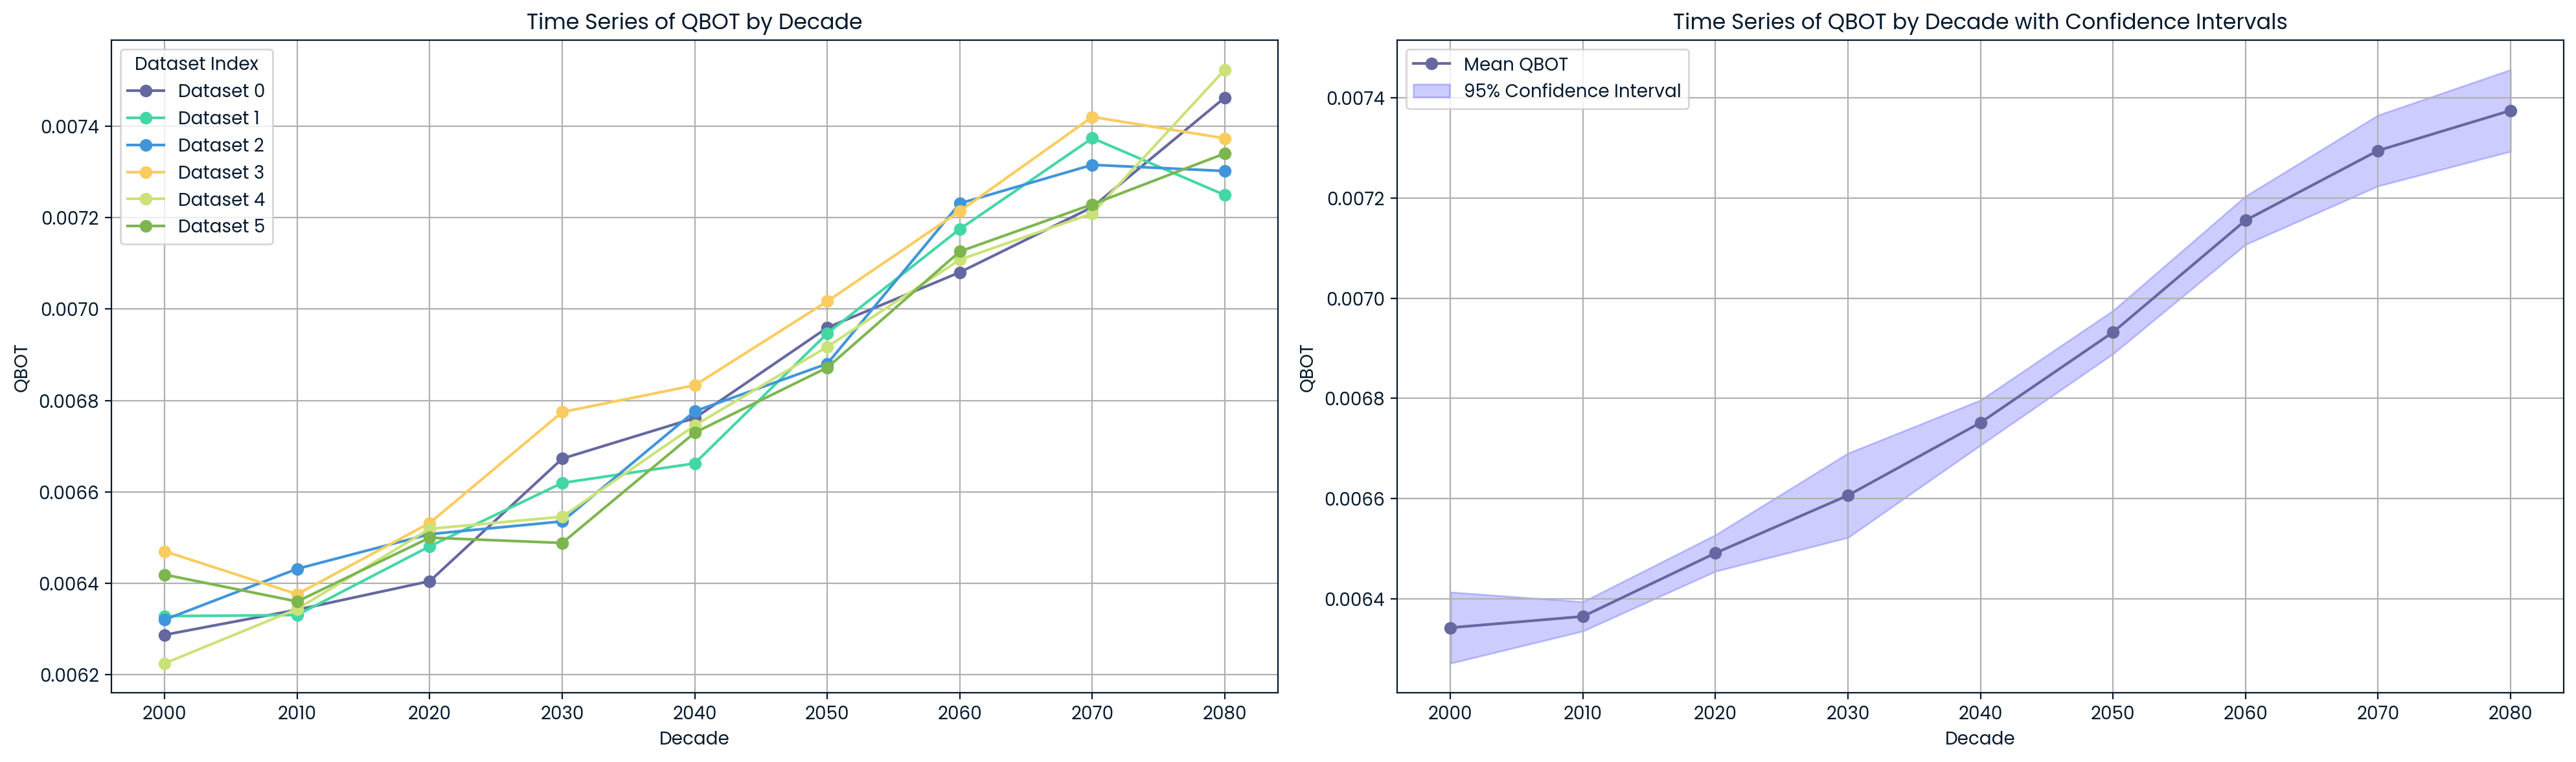

UBOT


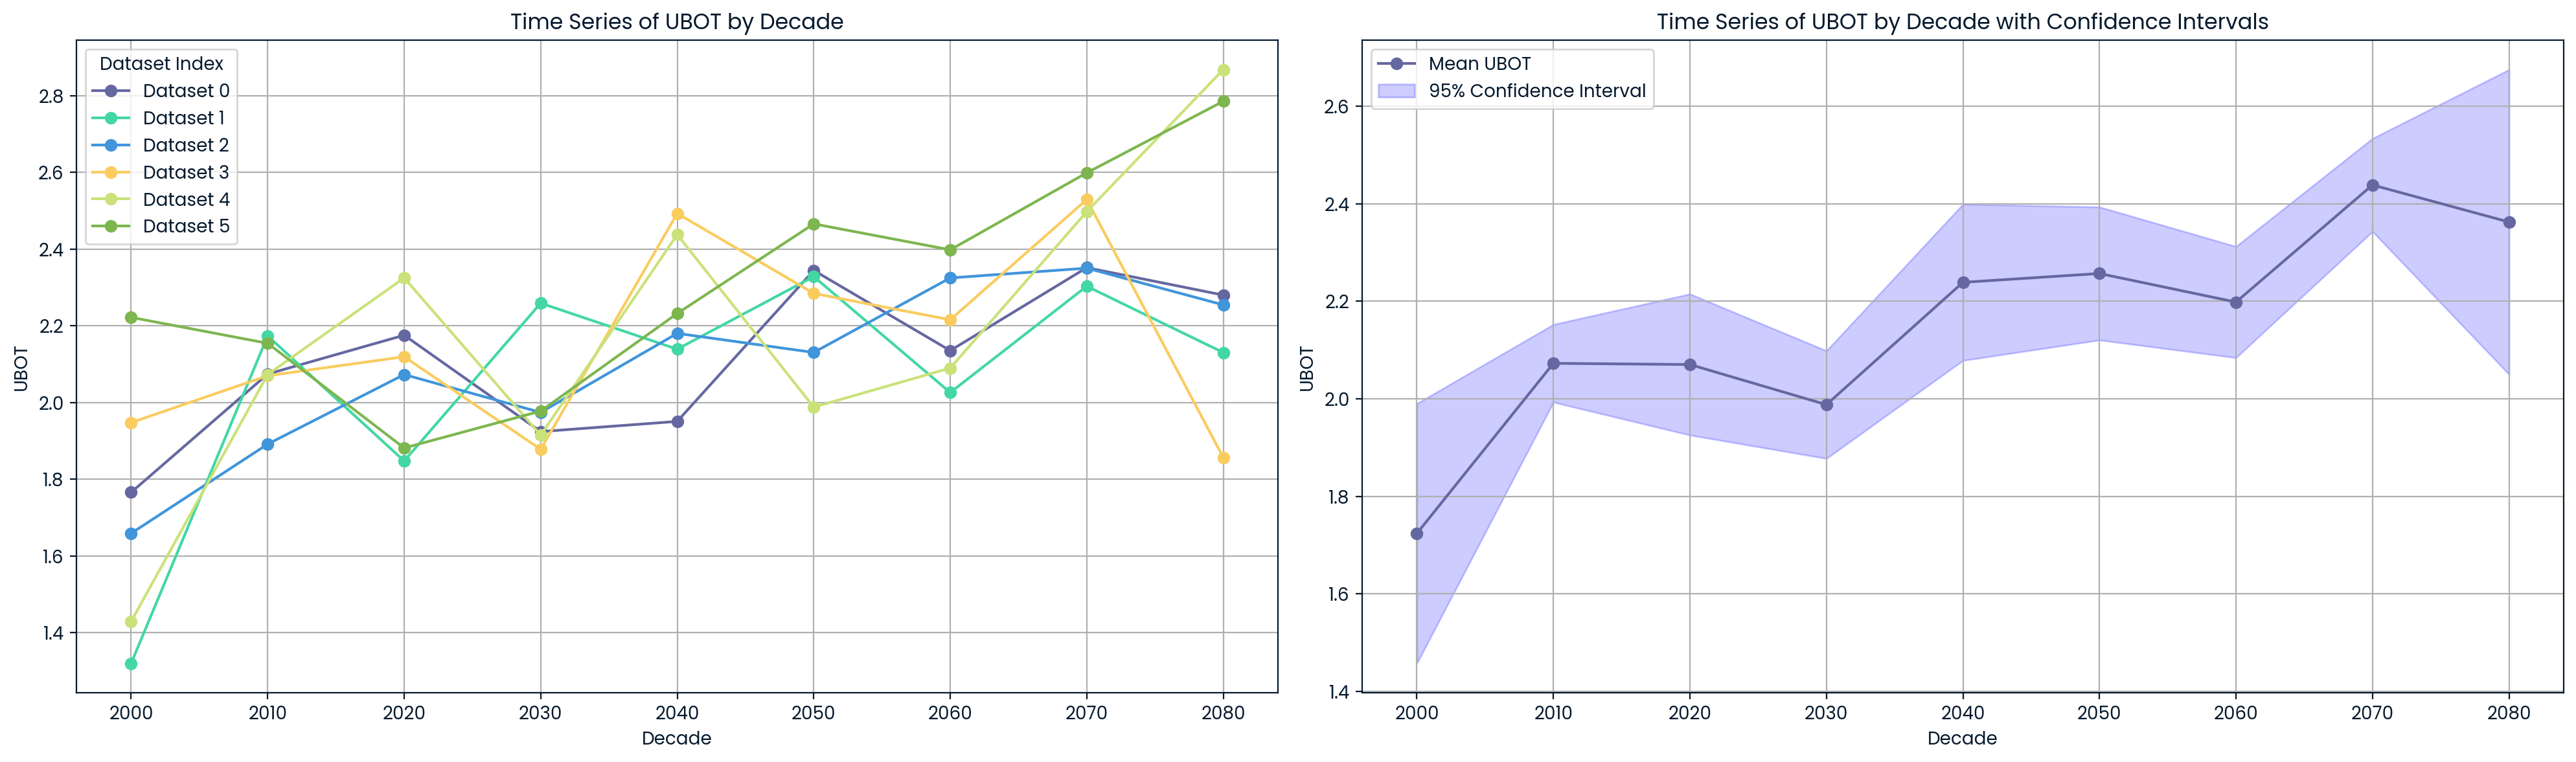

VBOT


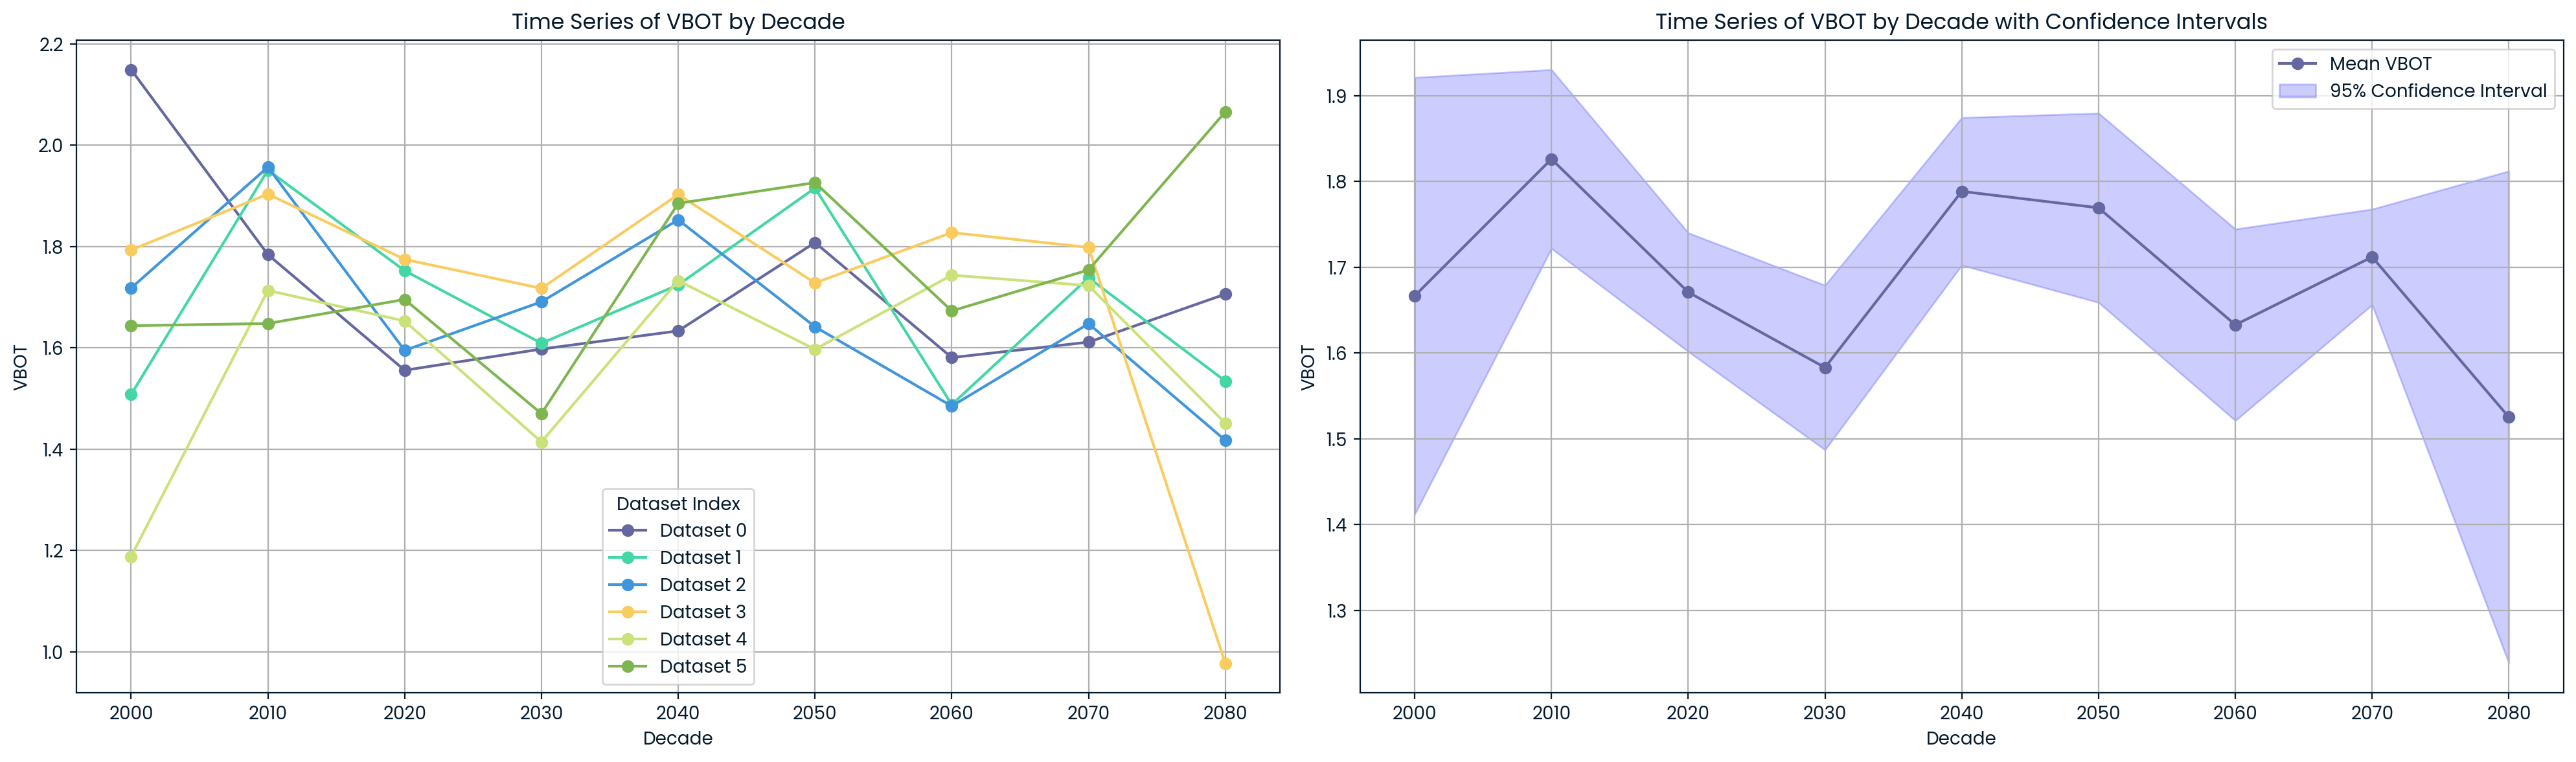

In [11]:
for attribute in attributes:
    print(attribute)
    # Prepare data
    ds_ts = ds[attribute].groupby(['decade', 'dataset_index']).mean()
    ds_ts = ds_ts.to_dataframe().reset_index()
    
    ds_ts = ds_ts.groupby(['decade', 'dataset_index'])[attribute].mean().reset_index()
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plotting the time series with legend by dataset_index on the first subplot
    for dataset_index in ds_ts['dataset_index'].unique():
        subset = ds_ts[ds_ts['dataset_index'] == dataset_index]
        axes[0].plot(subset['decade'], subset[attribute], marker='o', linestyle='-', label=f'Dataset {dataset_index}')
    axes[0].set_xlabel('Decade')
    axes[0].set_ylabel(attribute)
    axes[0].set_title(f'Time Series of {attribute} by Decade')
    axes[0].legend(title='Dataset Index')
    axes[0].grid(True)
    
    # Calculate mean and confidence intervals
    mean_ts = ds_ts.groupby('decade')[attribute].mean()
    conf_int = ds_ts.groupby('decade')[attribute].agg(lambda x: (x.mean() - 1.96 * x.std() / (len(x) ** 0.5), x.mean() + 1.96 * x.std() / (len(x) ** 0.5)))
    
    # Plotting the time series with confidence intervals on the second subplot
    axes[1].plot(mean_ts.index, mean_ts.values, marker='o', linestyle='-', label=f'Mean {attribute}')
    axes[1].fill_between(conf_int.index, conf_int.apply(lambda x: x[0]), conf_int.apply(lambda x: x[1]), color='b', alpha=0.2, label='95% Confidence Interval')
    axes[1].set_xlabel('Decade')
    axes[1].set_ylabel(attribute)
    axes[1].set_title(f'Time Series of {attribute} by Decade with Confidence Intervals')
    axes[1].legend()
    axes[1].grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()